# Feature engineering

Ce notebook constitue la deuxième phase du projet de scoring crédit. Il transforme les données brutes de 7 tables relationnelles en features prédictives pour la modélisation. L'objectif est de créer des variables agrégées capturant l'historique financier et comportemental des clients, tout en optimisant les performances grâce à MLflow tracking.


In [1]:
import numpy as np
import pandas as pd
import gc
import time
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ajouter le chemin du projet
notebook_dir = Path().absolute()
project_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.append(str(project_dir))

In [2]:
# Configuration MLflow
import mlflow
import mlflow.sklearn
from datetime import datetime

# Fermer tout run actif (si un ancien run est encore ouvert)
while mlflow.active_run():
    run_info = mlflow.active_run().info
    print(f"Fermeture du run précédent: {run_info.run_name} (id: {run_info.run_id})")
    mlflow.end_run()

# Définir l'URI de tracking MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Nom de l'expérience
experiment_name = "2-credit-scoring-feature-engineering"
mlflow.set_experiment(experiment_name)

# Démarrer un run MLflow manuellement
mlflow_run = mlflow.start_run(run_name="data_credit-scoring-feature-engineering")

# Vérification
print(f" MLflow - Expérience: {experiment_name}")
print(f" Run démarré: {mlflow_run.info.run_name} (id: {mlflow_run.info.run_id})")

# Timer pour mesurer les performances
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

 MLflow - Expérience: 2-credit-scoring-feature-engineering
 Run démarré: data_credit-scoring-feature-engineering (id: 1ea239073b73466db5442ae80ce4c943)


Configuration de l'environnement avec tracking MLflow pour mesurer les performances de transformation.

In [3]:
# One-hot encoding pour les colonnes catégorielles
def one_hot_encoder(df, nan_as_category=True):
    """
    Transforme les variables catégorielles en variables binaires (one-hot encoding)
    
    Args:
        df: DataFrame à encoder
        nan_as_category: Si True, traite les valeurs NaN comme une catégorie distincte
    
    Returns:
        df_encoded: DataFrame avec variables catégorielles encodées
        new_columns: Liste des nouvelles colonnes créées par l'encodage
    """   
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

Fonction utilitaire pour encoder les variables catégorielles. Elle transforme automatiquement toutes les colonnes 'object' en variables binaires, facilitant leur utilisation dans les algorithmes ML. Le paramètre nan_as_category traite les valeurs manquantes comme une catégorie distincte, conservant l'information de "données manquantes".


In [4]:
def application_train_test(num_rows=None, nan_as_category=False):
    """
    Charge et prétraite les données principales d'application de crédit.
    Fusionne train et test pour un preprocessing uniforme, puis applique les transformations de base (nettoyage, encodage, feature engineering).
    """ 
    
    # Définir le chemin des données
    data_dir = os.path.join(project_dir, 'data', 'source')
    df = pd.read_csv(os.path.join(data_dir, 'application_train.csv'), nrows=num_rows)
    test_df = pd.read_csv(os.path.join(data_dir, 'application_test.csv'), nrows=num_rows)
    print(f"Train samples: {len(df)}, test samples: {len(test_df)}")
    df = pd.concat([df, test_df]).reset_index(drop=True)
    
    # Définir SK_ID_CURR comme index
    if 'SK_ID_CURR' in df.columns:
        df = df.set_index('SK_ID_CURR')
    
    # Supprimer les entrées avec CODE_GENDER=XNA
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encodage des variables catégorielles binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    
    # One-hot encoding pour les autres variables catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Traitement de l'anomalie DAYS_EMPLOYED
    df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED'] == 365243
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Création de features dérivées
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    del test_df
    gc.collect()
    return df

In [5]:
def bureau_and_balance(num_rows=None, nan_as_category=False):
    """
    Traite les données du bureau de crédit et les historiques de balance.
    Crée des agrégations statistiques par client pour capturer l'historique
    de crédit (tous crédits, actifs, fermés) en tant que features prédictives.
    """
    # Charger les données du bureau de crédit et historiques balance
    data_dir = os.path.join(project_dir, 'data', 'source')
    bureau = pd.read_csv(os.path.join(data_dir, 'bureau.csv'), nrows=num_rows)
    bb = pd.read_csv(os.path.join(data_dir, 'bureau_balance.csv'), nrows=num_rows)
    
    # Encodage des variables catégorielles pour les deux tables
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégation des balances par crédit bureau (niveau SK_ID_BUREAU)
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat: bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    
    # Fusion des agrégations balance avec les données bureau
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg; gc.collect()
    
    # Définition des agrégations par type de variable (historique de crédit)
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Correction de la syntaxe de fusion des dictionnaires
    cat_aggregations = {**{cat: ['mean'] for cat in bureau_cat},
                        **{cat + "_MEAN": ['mean'] for cat in bb_cat}}
    
    # Agrégation globale par client (tous les crédits confondus)
    # Correction de la syntaxe pour éviter l'erreur TypeError
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Agrégation spécifique : crédits actifs seulement
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg; gc.collect()
    
    # Agrégation spécifique : crédits fermés seulement
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau; gc.collect()
    
    return bureau_agg

Cette fonction traite les données du bureau de crédit (historique avec autres institutions) et les balances mensuelles associées. Elle crée des agrégations globales puis spécialisées (crédits actifs vs fermés) pour capturer différents profils de comportement financier. Les préfixes BURO_, ACTIVE_, CLOSED_ permettent d'identifier l'origine des features.


In [6]:
def previous_applications(num_rows=None, nan_as_category=False):
    """
    Traite les données des demandes de crédit précédentes.
    Crée des agrégations par client pour capturer l'historique de demandes (toutes, approuvées, refusées) comme features prédictives du comportement.
    """
    
    # Charger les données
    data_dir = os.path.join(project_dir, 'data', 'source')
    prev = pd.read_csv(os.path.join(data_dir, 'previous_application.csv'), nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=False)
    
    # Remplacer les valeurs anomaliques (365243) par NaN
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
                'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        prev[col].replace(365243, np.nan, inplace=True)
    
    # Ajouter pourcentage demandé vs reçu
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Définir les agrégations pour variables numériques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    # Agrégations pour variables catégorielles
    cat_aggregations = {cat: ['mean'] for cat in cat_cols}
    
    # Agrégations pour toutes les demandes
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Agrégations pour demandes approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Agrégations pour demandes refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev; gc.collect()
    
    return prev_agg

Traitement des demandes de crédit précédentes chez "Prêt à dépenser". La segmentation (APPROVED/REFUSED) capture des patterns comportementaux distincts : les clients ayant des demandes refusées présentent potentiellement un profil de risque différent. Les ratios calculés (montant demandé vs accordé) sont des élements fortement prédictifs.

In [7]:
def pos_cash(num_rows=None, nan_as_category=False):
    """
    Traite les données des balances POS (Point of Sale) et crédits cash.
    Agrège les historiques de paiement et retards pour créer des features de comportement financier sur les crédits à la consommation précédents.
    """
    
    # Charger les données
    data_dir = os.path.join(project_dir, 'data', 'source')
    pos = pd.read_csv(os.path.join(data_dir, 'POS_CASH_balance.csv'), nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)
    
    # Définir les agrégations
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        **{cat: ['mean'] for cat in cat_cols}
    }
    
    # Calculer les agrégations
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Ajouter le nombre de comptes
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos; gc.collect()
    return pos_agg

Analyse des balances POS (Point of Sale) et crédits cash. Ces données reflètent l'utilisation de crédits renouvelables et le comportement de remboursement à court terme. Les retards (SK_DPD) sont des indicateurs de difficulté financière future.


In [8]:
def installments_payments(num_rows=None, nan_as_category=False):
    """
    Traite les données des paiements d'échéances (installments).
    Calcule des métriques de comportement de paiement (retards, avances, différences) et agrège par client pour créer des features prédictives.
    """
    
    # Charger les données
    data_dir = os.path.join(project_dir, 'data', 'source')
    ins = pd.read_csv(os.path.join(data_dir, 'installments_payments.csv'), nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=False)
    
    # Calculer les métriques de paiement
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Calculer les jours de retard et d'avance (valeurs positives uniquement)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: max(x, 0))
    ins['DBD'] = ins['DBD'].apply(lambda x: max(x, 0))
    
    # Définir les agrégations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        **{cat: ['mean'] for cat in cat_cols}
    }
    
    # Calculer les agrégations
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins; gc.collect()
    return ins_agg

Traitement des historiques de paiement d'échéances. Cette table contient l'information la plus granulaire sur le comportement de remboursement. Les écarts entre montants dus et payés, ainsi que les retards, constituent des signaux prédictifs majeurs du risque de défaut.


In [9]:
def credit_card_balance(num_rows=None, nan_as_category=False):
    """
    Traite les données des balances de cartes de crédit.
    Agrège tous les indicateurs de comportement carte (soldes, limites, utilisations, retards) par client pour enrichir le profil de risque.
    """

    # Charger les données
    data_dir = os.path.join(project_dir, 'data', 'source')
    cc = pd.read_csv(os.path.join(data_dir, 'credit_card_balance.csv'), nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
    
    # Supprimer colonne inutile et calculer agrégations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc; gc.collect()
    return cc_agg

Analyse des balances de cartes de crédit mensuelles. Le comportement sur carte de crédit (utilisation, remboursement, dépassements) reflète la gestion financière quotidienne. Les ratios d'utilisation et les patterns de paiement minimum sont particulièrement informatifs.


# Assemblage et préparation finale des données

In [10]:
def main(debug=False):
    """
    Pipeline principal de feature engineering.
    Orchestre le chargement, le preprocessing et l'agrégation de toutes les tables pour créer un dataset enrichi prêt pour la modélisation.
    """
    
    # Paramètre pour débugger avec moins de données
    num_rows = 10000 if debug else None
    
    # Tracking
    mlflow.log_param("debug_mode", debug)
    mlflow.log_param("num_rows_limit", num_rows if num_rows else "all")
    mlflow.log_param("pipeline_date", datetime.now().strftime("%Y-%m-%d %H:%M"))
    mlflow.log_param("analyst", "Brice_Béchet")
    
    print(f" Début du pipeline Feature Engineering - Debug: {debug}")
    
    # Application train/test
    df = application_train_test(num_rows)
    
    # Tracking
    mlflow.log_metric("base_train_rows", df[df['TARGET'].notnull()].shape[0])
    mlflow.log_metric("base_test_rows", df[df['TARGET'].isnull()].shape[0])
    mlflow.log_metric("base_features_count", df.shape[1])
    mlflow.log_param("base_tables_loaded", "application_train_test")
    
    # Bureau and bureau balance
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
    
    # Mesurer l'impact de la jointure
    features_before = df.shape[1]
    df = df.join(bureau, how='left')
    features_after = df.shape[1]
    
    # Tracking
    mlflow.log_metric("bureau_table_rows", bureau.shape[0])
    mlflow.log_metric("bureau_features_added", features_after - features_before)
    mlflow.log_metric("total_features_after_bureau", features_after)
    mlflow.log_param("bureau_aggregation_strategy", "min_max_mean_var")
    del bureau
    gc.collect()
    
    # Previous applications
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
    
    # Mesurer l'impact
    features_before = df.shape[1]
    df = df.join(prev, how='left')
    features_after = df.shape[1]
    
    # Tracking
    mlflow.log_metric("prev_apps_table_rows", prev.shape[0])
    mlflow.log_metric("prev_apps_features_added", features_after - features_before)
    mlflow.log_metric("total_features_after_prev", features_after)
    mlflow.log_param("prev_apps_segmentation", "approved_refused_all")
    print(f" Previous applications tracké - +{features_after - features_before} features")
    del prev
    gc.collect()
    
    # POS-CASH balance
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
    
    features_before = df.shape[1]
    df = df.join(pos, how='left')
    features_after = df.shape[1]
    
    # Tracking
    mlflow.log_metric("pos_cash_table_rows", pos.shape[0])
    mlflow.log_metric("pos_cash_features_added", features_after - features_before)
    mlflow.log_metric("total_features_after_pos", features_after)
    del pos
    gc.collect()
    
    # Installments payments
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
    
    features_before = df.shape[1]
    df = df.join(ins, how='left')
    features_after = df.shape[1]
    
    # Tracking
    mlflow.log_metric("installments_table_rows", ins.shape[0])
    mlflow.log_metric("installments_features_added", features_after - features_before)
    mlflow.log_metric("total_features_after_installments", features_after)
    del ins
    gc.collect()
    
    # Credit card balance
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
    
    features_before = df.shape[1]
    df = df.join(cc, how='left')
    features_after = df.shape[1]
    
    # Tracking
    mlflow.log_metric("credit_card_table_rows", cc.shape[0])
    mlflow.log_metric("credit_card_features_added", features_after - features_before)
    mlflow.log_metric("total_features_after_cc", features_after)
    del cc
    gc.collect()
    
    # Diviser en train et test pour la prochaine étape
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    
    # Tracking
    mlflow.log_metric("final_train_rows", train_df.shape[0])
    mlflow.log_metric("final_test_rows", test_df.shape[0])
    mlflow.log_metric("final_features_total", train_df.shape[1])
    mlflow.log_metric("features_multiplication_factor", train_df.shape[1] / 122)
    
    # Statistiques de création de features
    total_added = train_df.shape[1] - 122
    mlflow.log_metric("total_features_added", total_added)
    mlflow.log_param("feature_engineering_success", True)
    
    print("Feature engineering")
    print(f"Données d'entraînement: {train_df.shape}")
    print(f"Données de test: {test_df.shape}")
    
    return train_df, test_df

# Exécution du feature engineering

In [11]:
# Exécuter le feature engineering
train_df, test_df = main(debug=False)

# Afficher les premières lignes du résultat
train_df.head()

 Début du pipeline Feature Engineering - Debug: False
Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 112)
Process bureau and bureau_balance - done in 16s
Previous applications df shape: (338857, 233)
Process previous_applications - done in 17s
 Previous applications tracké - +233 features
Pos-cash balance df shape: (337252, 17)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 23s
Credit card balance df shape: (103558, 136)
Process credit card balance - done in 11s
Feature engineering
Données d'entraînement: (307507, 771)
Données de test: (48744, 771)


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Résultat : transformation réussie de 122 variables initiales en 771 features.


#  Valeurs infinies, manquantes et abérantes

##  Valeurs infinies

Phase de nettoyage des données. Les agrégations peuvent générer des valeurs infinies (division par zéro) ou aberrantes. Cette étape garantit la stabilité numérique des algorithmes ML et évite les erreurs de convergence. Le traitement des valeurs manquantes préserve l'information tout en assurant la compatibilité avec scikit-learn.


In [12]:
# Détecter et afficher les colonnes avec valeurs infinies
def detect_infinite_values(df, name="DataFrame"):
    """
    Détecte les valeurs infinies dans un DataFrame pour identifier
    les problèmes de division par zéro ou calculs aberrants nécessitant un traitement avant modélisation.
    """
    
    # Compter les valeurs infinies dans les colonnes numériques
    inf_counts = pd.Series({col: np.isinf(df[col]).sum()
                           for col in df.select_dtypes(include=['number']).columns})
    
    # Filtrer uniquement les colonnes avec valeurs infinies
    inf_columns = inf_counts[inf_counts > 0].sort_values(ascending=False)
    
    # Afficher le résultat
    print(f"Colonnes contenant des valeurs infinies dans {name}:")
    print(inf_columns if len(inf_columns) > 0 else "Aucune")
    
    return inf_columns.index.tolist()

# Exécuter sur les deux DataFrames
train_inf_cols = detect_infinite_values(train_df, "train_df")
test_inf_cols = detect_infinite_values(test_df, "test_df")

# Afficher les types de données
print("\nTypes de données dans train_df:")
print(train_df.dtypes.value_counts())

print("\nTypes de données dans test_df:")
print(test_df.dtypes.value_counts())

Colonnes contenant des valeurs infinies dans train_df:
INSTAL_PAYMENT_PERC_MAX        18
PREV_APP_CREDIT_PERC_MAX        1
REFUSED_APP_CREDIT_PERC_MAX     1
dtype: int64
Colonnes contenant des valeurs infinies dans test_df:
INSTAL_PAYMENT_PERC_MAX    1
dtype: int64

Types de données dans train_df:
float64    582
bool       134
int64       41
object      14
Name: count, dtype: int64

Types de données dans test_df:
float64    582
bool       134
int64       41
object      14
Name: count, dtype: int64


Détection systématique des valeurs infinies pouvant compromettre l'entraînement. Les opérations de division dans les agrégations peuvent générer des inf/-inf qu'il faut identifier et traiter avant la modélisation.


In [13]:
# Fonction detect_infinites
def detect_infinites(df, name="DataFrame"):
    """
    Détecte et affiche les colonnes avec valeurs infinies avec comptage détaillé.
    Version améliorée avec affichage du nombre de valeurs infinies par colonne.
    """
    # Compter les valeurs infinies dans les colonnes numériques
    inf_counts = pd.Series({col: np.isinf(df[col]).sum()
                           for col in df.select_dtypes(include=['number']).columns})
    
    # Filtrer uniquement les colonnes avec valeurs infinies
    inf_columns = inf_counts[inf_counts > 0].sort_values(ascending=False)
    
    # Afficher le résultat
    print(f"Colonnes contenant des valeurs infinies dans {name}:")
    if len(inf_columns) > 0:
        for col, count in inf_columns.items():
            print(f"{col}: {count}")
    else:
        print("Aucune")
    
    return inf_columns.index.tolist()

# Traitement des valeurs infinies
def replace_infinites(train_df, test_df):
    """
    Remplace les valeurs infinies par des valeurs appropriées médiane ou valeur fixe selon le contexte de la variable.
    """
    # Définir la stratégie de remplacement
    replacement_strategy = {
        'INSTAL_PAYMENT_PERC_MAX': 1.0,  # Valeur fixe
        'INSTAL_PAYMENT_PERC_MEAN': None,  # Médiane
        'INSTAL_PAYMENT_PERC_SUM': None,  # Médiane
        'PREV_APP_CREDIT_PERC_MAX': None,  # Médiane
        'PREV_APP_CREDIT_PERC_MEAN': None,  # Médiane
        'REFUSED_APP_CREDIT_PERC_MAX': None,  # Médiane
        'REFUSED_APP_CREDIT_PERC_MEAN': None  # Médiane
    }
    
    # Calculer les médianes si nécessaire
    for col in replacement_strategy:
        if replacement_strategy[col] is None and col in train_df.columns:
            replacement_strategy[col] = train_df[col].replace([np.inf, -np.inf], np.nan).median()
    
    # Remplacer les valeurs infinies
    for col, value in replacement_strategy.items():
        if col in train_df.columns:
            train_df[col] = train_df[col].replace([np.inf, -np.inf], value)
        if col in test_df.columns:
            test_df[col] = test_df[col].replace([np.inf, -np.inf], value)
    
    # Vérifier qu'il ne reste plus de valeurs infinies
    train_inf = np.isinf(train_df.select_dtypes(include=['number'])).sum().sum()
    test_inf = np.isinf(test_df.select_dtypes(include=['number'])).sum().sum()
    
    return train_inf, test_inf

# Tracking
mlflow.log_param("infinite_values_check", True)

# Avant remplacement
print("Avant remplacement:")
train_inf_cols = detect_infinites(train_df, "train_df")
test_inf_cols = detect_infinites(test_df, "test_df")

# Compter les valeurs infinies
train_inf_total = np.isinf(train_df.select_dtypes(include=['number'])).sum().sum()
test_inf_total = np.isinf(test_df.select_dtypes(include=['number'])).sum().sum()

mlflow.log_metric("infinite_values_train_before", train_inf_total)
mlflow.log_metric("infinite_values_test_before", test_inf_total)
mlflow.log_metric("infinite_columns_train", len(train_inf_cols))
mlflow.log_metric("infinite_columns_test", len(test_inf_cols))

# Remplacer les valeurs infinies
train_inf_count, test_inf_count = replace_infinites(train_df, test_df)

mlflow.log_metric("infinite_values_train_after", train_inf_count)
mlflow.log_metric("infinite_values_test_after", test_inf_count)
mlflow.log_param("infinite_replacement_strategy", "median_and_fixed_values")

print("Après remplacement:")
print(f"Valeurs infinies restantes dans train_df: {train_inf_count}")
print(f"Valeurs infinies restantes dans test_df: {test_inf_count}")

Avant remplacement:
Colonnes contenant des valeurs infinies dans train_df:
INSTAL_PAYMENT_PERC_MAX: 18
PREV_APP_CREDIT_PERC_MAX: 1
REFUSED_APP_CREDIT_PERC_MAX: 1
Colonnes contenant des valeurs infinies dans test_df:
INSTAL_PAYMENT_PERC_MAX: 1
Après remplacement:
Valeurs infinies restantes dans train_df: 0
Valeurs infinies restantes dans test_df: 0


Remplacement des valeurs infinies par NaN pour un traitement uniforme. Cette approche préserve la structure des données et neutralise les valeurs problématiques qui seraient remplacées par 0 lors de l'imputation finale.


## Colonnes de type 'object'

In [14]:
# Identifier et analyser les colonnes de type 'object'
object_cols = train_df.select_dtypes(include=['object']).columns
print(f"Nombre de colonnes de type 'object': {len(object_cols)}")

# Analyse détaillée des colonnes catégorielles restantes après one-hot encoding
for col in object_cols:
   print(f"\n{col}")
   # Distribution des valeurs pour diagnostic (détection de booléens mal typés)
   value_counts = train_df[col].value_counts(dropna=False)
   print(value_counts.head(10))  # Top 10 des valeurs les plus fréquentes

Nombre de colonnes de type 'object': 14

CC_NAME_CONTRACT_STATUS_Active_MIN
CC_NAME_CONTRACT_STATUS_Active_MIN
NaN      220602
True      72218
False     14687
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Active_MAX
CC_NAME_CONTRACT_STATUS_Active_MAX
NaN      220602
True      86838
False        67
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Approved_MIN
CC_NAME_CONTRACT_STATUS_Approved_MIN
NaN      220602
False     86905
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Approved_MAX
CC_NAME_CONTRACT_STATUS_Approved_MAX
NaN      220602
False     86900
True          5
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Completed_MIN
CC_NAME_CONTRACT_STATUS_Completed_MIN
NaN      220602
False     86878
True         27
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Completed_MAX
CC_NAME_CONTRACT_STATUS_Completed_MAX
NaN      220602
False     76297
True      10608
Name: count, dtype: int64

CC_NAME_CONTRACT_STATUS_Demand_MIN
CC_NAME_CONTRACT_STATUS_Demand_MIN
NaN      220602

In [15]:
# Conversion des colonnes booléennes stockées comme 'object' vers float64
bool_cols = []
for col in train_df.select_dtypes(include=['object']).columns:
    # Vérifier si la colonne ne contient que des valeurs booléennes (True/False)
    if set(train_df[col].dropna().unique()).issubset({True, False}):
        bool_cols.append(col)
        
       # Conversion train_df : True→1.0, False→0.0, NaN préservé
        train_df[col] = train_df[col].map({True: 1.0, False: 0.0}).astype('float64')
        
       # Conversion test_df avec vérification de cohérence
        if col in test_df.columns:
            test_df[col] = test_df[col].map({True: 1.0, False: 0.0}).astype('float64')

# Afficher le résultat
print(f"Converti {len(bool_cols)} colonnes booléennes de 'object' vers 'float64'")
print(f"Colonnes 'object' restantes: {len(train_df.select_dtypes(include=['object']).columns)}")

Converti 14 colonnes booléennes de 'object' vers 'float64'
Colonnes 'object' restantes: 0


## NaN, zéros et outliers

In [16]:
# Analyse des données: NaN, zéros et outliers
n_rows = len(train_df)

# Calcul des valeurs manquantes
missing = train_df.isnull().sum()
missing_pct = missing / n_rows * 100

# Calcul des zéros
zeros = (train_df == 0).sum()
zeros_pct = zeros / n_rows * 100

# Calcul des outliers via méthode IQR  (pour colonnes numériques)
outliers = pd.Series(0, index=train_df.columns)
for col in train_df.select_dtypes(include=['number']).columns:
    Q1, Q3 = train_df[col].quantile(0.25), train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    bounds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    outliers[col] = ((train_df[col] < bounds[0]) | (train_df[col] > bounds[1])).sum()

outliers_pct = outliers / n_rows * 100

# Créer le tableau récapitulatif
results = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct,
    'Zero Count': zeros,
    'Zero %': zeros_pct,
    'Outliers Count': outliers,
    'Outliers %': outliers_pct
}).sort_values('Missing %', ascending=False)

# Afficher les résultats
print(results.head(20))
print(f"Total de valeurs manquantes: {missing.sum()}")
print(f"Total de zéros: {zeros.sum()}")
print(f"Total de valeurs aberrantes: {outliers.sum()}")

                                   Missing Count  Missing %  Zero Count  \
REFUSED_AMT_DOWN_PAYMENT_MEAN             262339  85.311554       23221   
REFUSED_RATE_DOWN_PAYMENT_MEAN            262339  85.311554       23221   
REFUSED_RATE_DOWN_PAYMENT_MAX             262339  85.311554       23221   
REFUSED_RATE_DOWN_PAYMENT_MIN             262339  85.311554       28695   
REFUSED_AMT_DOWN_PAYMENT_MIN              262339  85.311554       28695   
REFUSED_AMT_DOWN_PAYMENT_MAX              262339  85.311554       23221   
REFUSED_APP_CREDIT_PERC_VAR               258350  84.014348       10234   
CC_AMT_PAYMENT_CURRENT_VAR                246888  80.286953         510   
CC_AMT_DRAWINGS_POS_CURRENT_VAR           246814  80.262888       26750   
CC_CNT_DRAWINGS_ATM_CURRENT_VAR           246814  80.262888        9687   
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR         246814  80.262888       54998   
CC_CNT_DRAWINGS_POS_CURRENT_VAR           246814  80.262888       26761   
CC_AMT_DRAWINGS_OTHER_CUR

In [17]:
# Supprimer les colonnes avec trop de valeurs manquantes (>80%)
missing_percentage = train_df.isnull().mean() * 100
threshold = 80
columns_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

mlflow.log_param("missing_threshold_percent", threshold)
mlflow.log_metric("columns_to_drop_count", len(columns_to_drop))
mlflow.log_metric("features_before_drop", train_df.shape[1])

# Supprimer les colonnes
train_df = train_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

mlflow.log_metric("features_after_drop", train_df.shape[1])
mlflow.log_metric("features_dropped", len(columns_to_drop))

print(f"Nombre de colonnes à supprimer: {len(columns_to_drop)}")
print(f"Nouvelles dimensions - train: {train_df.shape}, test: {test_df.shape}")

Nombre de colonnes à supprimer: 37
Nouvelles dimensions - train: (307507, 734), test: (48744, 734)


In [18]:
# Analyse de la distribution des zéros
zero_pct = (train_df == 0).mean() * 100

# Statistiques générales
print("\nStatistiques sur les zéros par colonne:")
print(zero_pct.describe())

# Distribution par plages de pourcentage
print("\nRépartition des colonnes par % de zéros:")
for start, end in zip([0, 10, 25, 50, 75, 90], [10, 25, 50, 75, 90, 100]):
    count = ((zero_pct >= start) & (zero_pct < end)).sum()
    print(f"{start:3d}% à {end:3d}%: {count:3d} colonnes")


Statistiques sur les zéros par colonne:
count    734.000000
mean      46.747096
std       40.630570
min        0.000000
25%        1.603216
50%       36.002107
75%       92.842439
max       99.999350
dtype: float64

Répartition des colonnes par % de zéros:
  0% à  10%: 257 colonnes
 10% à  25%:  48 colonnes
 25% à  50%:  89 colonnes
 50% à  75%:  60 colonnes
 75% à  90%:  78 colonnes
 90% à 100%: 202 colonnes


Dans le contexte du crédit, des événements rares peuvent être extrêmement prédictifs. Nous utilisons LightGBM afin d'évaluer l'importance des features et tester l'impact des colonnes avec beaucoup de zéros sur les performances du modèle.

In [19]:
#  Normalisation des variables numériques

In [20]:
from sklearn.preprocessing import StandardScaler

# Identifier d'abord les colonnes numériques
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Identifier les variables à normaliser (numériques non binaires)
binary_pattern = (train_df[numeric_cols] == 0) | (train_df[numeric_cols] == 1)
binary_cols = binary_pattern.all().index[binary_pattern.all()]
cols_to_scale = [col for col in numeric_cols if col not in binary_cols and col != 'TARGET']

print(f"Nombre de variables possiblement à normaliser: {len(cols_to_scale)}")

Nombre de variables possiblement à normaliser: 564


In [21]:
print(f"\nVariables à normaliser: {cols_to_scale}")


Variables à normaliser: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGI

cols_to_scale contient beaucoup de variables qui ne sont pas à normaliser.
- Variable d'identification (SK_ID_CURR)
- Variables binaires encodées qui se terminent par _MEAN, _SUM etc
- Pourcentages et ratios déjà à l'échelle comme toutes les variables PERC  (DAYS_EMPLOYED_PERC, INCOME_CREDIT_PERC ...)
- Variables déjà normalisées comme EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

La normalisation est pertinente pour des approches sensibles à l'échelle des variables (Régression logistique, SVM, K-means ...). Les algorythmes de type arbres de décision (Random Forest, XGBoost, LightGBM) sont eux insensibles. Pour le moment la normalisation n'est pas mise en oeuvre

In [22]:
correlation_threshold = 0.8
mlflow.log_param("correlation_analysis_threshold", correlation_threshold)

# Sélectionner uniquement les variables numériques
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
mlflow.log_metric("numeric_columns_analyzed", len(numeric_cols))

# Calculer la matrice de corrélation
corr_matrix = train_df[numeric_cols].corr()

# Identifier les paires de variables fortement corrélées (seuil à 0.8)
strong_correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            strong_correlations.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Trier les corrélations par valeur absolue décroissante
sorted_correlations = sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True)

# Créer un DataFrame pour stocker les résultats
correlation_df = pd.DataFrame(sorted_correlations, columns=['Variable_1', 'Variable_2', 'Coefficient'])

# Tracking
mlflow.log_metric("high_correlation_pairs_detected", len(correlation_df))

if len(correlation_df) > 0:
    mlflow.log_metric("max_correlation_value", correlation_df['Coefficient'].abs().max())
    mlflow.log_metric("mean_correlation_value", correlation_df['Coefficient'].abs().mean())

# Définir le chemin de sortie dans data/processed
data_dir = os.path.join(project_dir, 'data', 'processed')
output_path = os.path.join(data_dir, "correlations_fortes.csv")

# Exporter le DataFrame vers un fichier CSV
correlation_df.to_csv(output_path, index=False)
mlflow.log_artifact(output_path)

print(f"Fichier CSV créé avec succès: {output_path}")
print(f"Nombre de paires de variables fortement corrélées: {len(correlation_df)}")

Fichier CSV créé avec succès: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\processed\correlations_fortes.csv
Nombre de paires de variables fortement corrélées: 578


#  Supprimer les variables redondantes

In [23]:
print(f"\nDimensions originales: train_df: {train_df.shape}, test_df: {test_df.shape}")

# Stocker les dimensions avant suppression
features_before_redundancy = train_df.shape[1]
mlflow.log_metric("features_before_redundancy_removal", features_before_redundancy)

# Liste des variables à supprimer avec leurs catégories
variables_to_remove = [
    # Variables parfaitement corrélées (r = 1 ou r = -1)
    'PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN',  # Garder PREV_NAME_CASH_LOAN_PURPOSE_
    'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',  # Garder PREV_CODE_REJECT_REASON_
    'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',  # Garder PREV_PRODUCT_COMBINATION_nan_MEAN
    'APPROVED_AMT_APPLICATION_MAX',  # Garder APPROVED_AMT_GOODS_PRICE_MAX
    'POS_MONTHS_BALANCE_SIZE',  # Garder POS_COUNT
    'CC_NAME_CONTRACT_STATUS_Refused_MEAN',  # Garder CC_NAME_CONTRACT_STATUS_Refused_
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN',  # Garder CC_NAME_CONTRACT_STATUS_
    'CC_NAME_CONTRACT_STATUS_Approved_MEAN',  # Garder CC_NAME_CONTRACT_STATUS_Approved_
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN',  # Garder PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN
    
    # Variables de cartes de crédit redondantes
    'CC_AMT_RECIVABLE_VAR', 'CC_AMT_RECIVABLE_MIN', 'CC_AMT_RECIVABLE_MEAN', 'CC_AMT_RECIVABLE_SUM',
    'CC_AMT_RECEIVABLE_PRINCIPAL_MIN', 'CC_AMT_RECEIVABLE_PRINCIPAL_MAX', 'CC_AMT_RECEIVABLE_PRINCIPAL_VAR',
    
    # Variables de demandes de prêt redondantes
    'PREV_AMT_APPLICATION_MAX', 'REFUSED_AMT_APPLICATION_MAX',
    'BURO_DAYS_CREDIT_MIN',  # Garder BURO_MONTHS_BALANCE_MIN_MIN
    'ACTIVE_DAYS_CREDIT_MIN',  # Garder ACTIVE_MONTHS_BALANCE_MIN_MIN
    'CLOSED_DAYS_CREDIT_MIN',  # Garder CLOSED_MONTHS_BALANCE_MIN_MIN
    
    # Variables immobilières - garder AVG et supprimer les autres
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
    'FLOORSMIN_MEDI', 'FLOORSMIN_MODE',
    'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
    'ENTRANCES_MEDI', 'ENTRANCES_MODE',
    'ELEVATORS_MEDI', 'ELEVATORS_MODE',
    'COMMONAREA_MEDI', 'COMMONAREA_MODE',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
    'APARTMENTS_MEDI', 'APARTMENTS_MODE',
    'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
    'LANDAREA_MEDI', 'LANDAREA_MODE',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE',
    
    # Variables liées aux montants des prêts
    'APPROVED_AMT_CREDIT_MAX',  # Corrélé avec APPROVED_AMT_GOODS_PRICE_MAX
    'REFUSED_AMT_CREDIT_MAX',  # Corrélé avec REFUSED_AMT_GOODS_PRICE_MAX
    'PREV_AMT_CREDIT_MAX',  # Corrélé avec PREV_AMT_GOODS_PRICE_MAX
    
    # Variables MEAN et MAX fortement corrélées
    'INSTAL_AMT_INSTALMENT_MAX',  # Garder INSTAL_AMT_PAYMENT_MAX
    'CLOSED_AMT_CREDIT_SUM_DEBT_MAX',  # Garder CLOSED_AMT_CREDIT_SUM_DEBT_SUM
    'BURO_AMT_CREDIT_SUM_DEBT_MAX',  # Garder BURO_AMT_CREDIT_SUM_DEBT_SUM
    'CC_SK_DPD_DEF_MAX',  # Garder CC_SK_DPD_DEF_SUM
    'CC_SK_DPD_MAX',  # Garder CC_SK_DPD_SUM
    
    # Variables géographiques redondantes
    'REG_REGION_NOT_WORK_REGION',  # Garder LIVE_REGION_NOT_WORK_REGION
    'REG_CITY_NOT_WORK_CITY',  # Garder LIVE_CITY_NOT_WORK_CITY
    
    # Variables dérivées
    'DAYS_EMPLOYED_PERC',  # Garder DAYS_EMPLOYED
    
    # Variables "similaires"
    'REGION_RATING_CLIENT_W_CITY',  # Garder REGION_RATING_CLIENT
    'INCOME_PER_PERSON',  # Garder AMT_INCOME_TOTAL
    'CC_NAME_CONTRACT_STATUS_Active_MEAN',  # Garder CC_NAME_CONTRACT_STATUS_Completed_MEAN
    'OBS_30_CNT_SOCIAL_CIRCLE',  # Garder OBS_60_CNT_SOCIAL_CIRCLE
    'DEF_30_CNT_SOCIAL_CIRCLE',  # Garder DEF_60_CNT_SOCIAL_CIRCLE
    
    # Variables fortement corrélées liées aux aggrégations
    'CC_AMT_PAYMENT_CURRENT_SUM',  # Garder CC_AMT_PAYMENT_TOTAL_CURRENT_SUM
    'CC_CNT_DRAWINGS_CURRENT_SUM',  # Garder CC_CNT_DRAWINGS_POS_CURRENT_SUM
    'ACTIVE_AMT_CREDIT_SUM_MAX',  # Garder ACTIVE_AMT_CREDIT_SUM_SUM
    'BURO_AMT_CREDIT_SUM_MAX',  # Garder BURO_AMT_CREDIT_SUM_SUM
    
    # Variables de balance et décisions
    'CC_MONTHS_BALANCE_MIN',
    'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_SUM',
    'CC_MONTHS_BALANCE_VAR',
    'APPROVED_DAYS_DECISION_MIN',
    'APPROVED_DAYS_DECISION_MEAN',
    'PREV_DAYS_DECISION_MIN',
    'PREV_DAYS_DECISION_MEAN',
    'REFUSED_DAYS_DECISION_MIN',
    'REFUSED_DAYS_DECISION_MEAN',
    'APPROVED_HOUR_APPR_PROCESS_START_MIN',
    'APPROVED_HOUR_APPR_PROCESS_START_MEAN',
    'APPROVED_APP_CREDIT_PERC_MIN',
    'APPROVED_APP_CREDIT_PERC_MEAN',
    'PREV_APP_CREDIT_PERC_MIN',
    'PREV_APP_CREDIT_PERC_MEAN',
    'REFUSED_APP_CREDIT_PERC_MIN',
    'REFUSED_APP_CREDIT_PERC_MEAN',
]


Dimensions originales: train_df: (307507, 734), test_df: (48744, 734)


In [24]:
# Supprimer les doublons
variables_to_remove = list(set(variables_to_remove))

# Statistiques sur les variables à supprimer
total_vars_to_remove = len(variables_to_remove)
mlflow.log_metric("total_redundant_vars_identified", total_vars_to_remove)

# Vérifier que toutes les variables à supprimer existent dans le DataFrame
variables_existing = [var for var in variables_to_remove if var in train_df.columns]
variables_missing = [var for var in variables_to_remove if var not in train_df.columns]

mlflow.log_metric("redundant_vars_actually_removed", len(variables_existing))
mlflow.log_metric("redundant_vars_not_found", len(variables_missing))

# Categoriser les variables supprimées
categories = {
    'perfectly_correlated': 9,
    'credit_card_redundant': 8,
    'loan_application_redundant': 5,
    'real_estate_redundant': 18,
    'amount_related': 3,
    'mean_max_correlated': 5,
    'geographic_redundant': 2,
    'derived_vars': 1,
    'similar_vars': 5,
    'aggregation_related': 4,
    'balance_decision_vars': 20
}

for category, count in categories.items():
    mlflow.log_metric(f"removed_vars_{category}", count)

# Tracking
mlflow.log_param("redundancy_removal_strategy", "correlation_analysis_and_domain_knowledge")
mlflow.log_param("redundancy_removal_categories", list(categories.keys()))

print(f"Nombre de variables à supprimer: {len(variables_existing)}")
if len(variables_missing) > 0:
    print(f"Variables non trouvées: {len(variables_missing)}")

# Créer des DataFrames avec les variables sélectionnées
train_df = train_df.drop(columns=variables_existing)
test_df = test_df.drop(columns=[v for v in variables_existing if v in test_df.columns])

# Mesurer l'impact de la suppression
features_after_redundancy = train_df.shape[1]
reduction_count = features_before_redundancy - features_after_redundancy
reduction_percentage = (reduction_count / features_before_redundancy) * 100

mlflow.log_metric("features_after_redundancy_removal", features_after_redundancy)
mlflow.log_metric("features_removed_count", reduction_count)
mlflow.log_metric("feature_reduction_percentage", reduction_percentage)

print(f"Dimensions réduites: train_df: {train_df.shape}, test_df: {test_df.shape}")

Nombre de variables à supprimer: 87
Dimensions réduites: train_df: (307507, 647), test_df: (48744, 647)


# Corrélations entre chaque variable et la cible

In [25]:
# Calculer les corrélations avec la variable cible TARGET
correlations_with_target = train_df.corr()['TARGET'].sort_values(ascending=False)

# Afficher les 20 corrélations les plus positives
print("20 corrélations les plus positives avec TARGET:")
print(correlations_with_target.head(20))

# Afficher les 20 corrélations les plus négatives
print("20 corrélations les plus négative avec TARGET:")
print(correlations_with_target.tail(20))

# Identifier les variables avec corrélation absolue supérieure au seuil de 0.1
threshold = 0.1
high_corr_abs = correlations_with_target.abs().sort_values(ascending=False)
high_corr_abs = high_corr_abs[high_corr_abs > threshold]

print(f"\nVariables avec corrélation absolue > {threshold} avec TARGET:")
print(high_corr_abs)

20 corrélations les plus positives avec TARGET:
TARGET                                    1.000000
CC_CNT_DRAWINGS_CURRENT_MAX               0.101389
BURO_DAYS_CREDIT_MEAN                     0.089731
CC_AMT_BALANCE_MEAN                       0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN              0.086490
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN          0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN              0.082520
DAYS_BIRTH                                0.078242
PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.077681
BURO_CREDIT_ACTIVE_Active_MEAN            0.077356
DAYS_EMPLOYED                             0.074957
CC_AMT_INST_MIN_REGULARITY_MEAN           0.073724
BURO_MONTHS_BALANCE_MIN_MIN               0.073225
BURO_DAYS_CREDIT_UPDATE_MEAN              0.068929
CC_AMT_BALANCE_MAX                        0.068798
CC_AMT_TOTAL_RECEIVABLE_MAX               0.068081
CC_AMT_RECIVABLE_MAX                      0.068066
REFUSED_DAYS_DECISION_MAX                 0.064230
CC_AMT_BALANCE_MIN                

Absence de variables avec corrélation <0.2 à la cible

#  Recherche de data leakage

In [26]:
# Identifier les variables temporelles potentiellement problématiques
time_vars = [col for col in train_df.columns if any(word in col.upper() for word in ['DAY', 'DAYS', 'DATE', 'TIME'])]
print(f"Nombre de variables temporelles identifiées: {len(time_vars)}")

# Vérifier que ces variables ne contiennent pas d'informations futures
suspicious_vars = []
for col in time_vars:
    # Vérifier uniquement les colonnes avec "DAYS" qui sont numériques
    if 'DAYS' in col and pd.api.types.is_numeric_dtype(train_df[col].dtype):
        if train_df[col].min() > 0:
            suspicious_vars.append((col, train_df[col].min()))

# Afficher les résultats
if suspicious_vars:
    print("\nVariables temporelles avec valeurs positives (potentiel data leakage):")
    for col, min_val in suspicious_vars:
        print(f" - {col}: valeur minimale = {min_val}")
else:
    print("\nToutes les variables avec les mots 'DAY','DAYS', 'DATE', 'TIME' ont des valeurs négatives ou nulles")

Nombre de variables temporelles identifiées: 57

Toutes les variables avec les mots 'DAY','DAYS', 'DATE', 'TIME' ont des valeurs négatives ou nulles


In [27]:
# Examiner les variables créées pendant le feature engineering
prefixes_to_check = ['APPROVED_', 'REFUSED_', 'PREV_', 'ACTIVE_', 'CLOSED_']

# Calculer les corrélations avec la variable cible TARGET
correlations_with_target = train_df.corr()['TARGET']

# Vérifier les corrélations élevées par préfixe
has_high_correlations = False
for prefix in prefixes_to_check:
    # Identifier les variables avec le préfixe actuel
    vars_with_prefix = [col for col in train_df.columns if col.startswith(prefix)]
    
    # Filtrer celles qui existent dans les corrélations et ont une valeur absolue > 0.2
    high_corr_vars = [v for v in vars_with_prefix if v in correlations_with_target.index 
                      and abs(correlations_with_target[v]) > 0.2]
    
    # Afficher les résultats si des variables à forte corrélation sont trouvées
    if high_corr_vars:
        has_high_correlations = True
        print(f"\nVariables '{prefix}' avec corrélation absolue > 0.2:")
        for col in high_corr_vars:
            print(f" - {col}: corr={correlations_with_target[col]:.4f}")

# Afficher un message si aucune variable n'a de forte corrélation
if not has_high_correlations:
    print("\nToutes les variables post-décision ont des corrélations absolues < 0.2 avec la variable cible.")


Toutes les variables post-décision ont des corrélations absolues < 0.2 avec la variable cible.


 Les préfixes indiquent qu'il s'agit d'informations sur des demandes/crédits précédents (PREV_, APPROVED_, REFUSED_, CLOSED_) ou d'autres crédits en cours (ACTIVE_)

# Analyse de feature importance

In [28]:
# Controle
# Informations de base sur train_df
print("train_df")
print(f"Dimensions: {train_df.shape[0]} lignes x {train_df.shape[1]} colonnes")
print("\nTypes de données:")
print(train_df.dtypes.value_counts())

# Informations de base sur test_df
print("\n\ntest_df")
print(f"Dimensions: {test_df.shape[0]} lignes x {test_df.shape[1]} colonnes")
print("\nTypes de données:")
print(test_df.dtypes.value_counts())

train_df
Dimensions: 307507 lignes x 647 colonnes

Types de données:
float64    475
bool       134
int64       38
Name: count, dtype: int64


test_df
Dimensions: 48744 lignes x 647 colonnes

Types de données:
float64    475
bool       134
int64       38
Name: count, dtype: int64


In [29]:
# Nettoyer les noms de colonnes pour LightGBM
def clean_feature_names(df):
    """Nettoie les noms pour LightGBM"""
    import re
    clean_cols = []
    for col in df.columns:
        clean_col = re.sub(r'[^A-Za-z0-9_]', '_', col)
        clean_col = re.sub(r'_{2,}', '_', clean_col)
        clean_col = clean_col.strip('_')
        clean_cols.append(clean_col)
    
    df_clean = df.copy()
    df_clean.columns = clean_cols
    return df_clean

# Appliquer le nettoyage définitif
train_df = clean_feature_names(train_df)
test_df = clean_feature_names(test_df)

print(f"Noms de colonnes nettoyés définitivement")

Noms de colonnes nettoyés définitivement


In [30]:
import lightgbm as lgb

# Configuration
COVERAGE_THRESHOLD = 99.9

# Tracking
mlflow.log_param("coverage_threshold", COVERAGE_THRESHOLD)
mlflow.log_param("selection_method", "LightGBM_importance")
mlflow.log_param("imputation_strategy", "median")

# Préparation des données
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

# Métriques de départ
mlflow.log_metric("features_input", X.shape[1])
mlflow.log_metric("samples_total", len(X))

# Entraîner un modèle LightGBM pour l'analyse d'importance
model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=100,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

model.fit(X, y)

# Calculer et organiser l'importance des features
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Value': model.feature_importances_
})
feature_imp = feature_imp.sort_values('Value', ascending=False).reset_index(drop=True)
feature_imp["pct"] = 100 * feature_imp['Value'] / feature_imp['Value'].sum()
feature_imp["pct_cum"] = np.cumsum(feature_imp["pct"])

# Identifier les features qui couvrent le pourcentage configuré
features_selected = feature_imp[feature_imp["pct_cum"] <= COVERAGE_THRESHOLD]

# Tracking
mlflow.log_metric("features_selected", len(features_selected))
mlflow.log_metric("selection_ratio", len(features_selected) / len(feature_imp))
mlflow.log_metric("top_feature_importance", feature_imp['Value'].iloc[0])

# Top 5 features importantes
for i in range(min(5, len(feature_imp))):
    mlflow.log_param(f"top_{i+1}_feature", feature_imp['Feature'].iloc[i])

print(f"\nNombre de features couvrant {COVERAGE_THRESHOLD}% de l'importance: {len(features_selected)}")


Nombre de features couvrant 99.9% de l'importance: 234


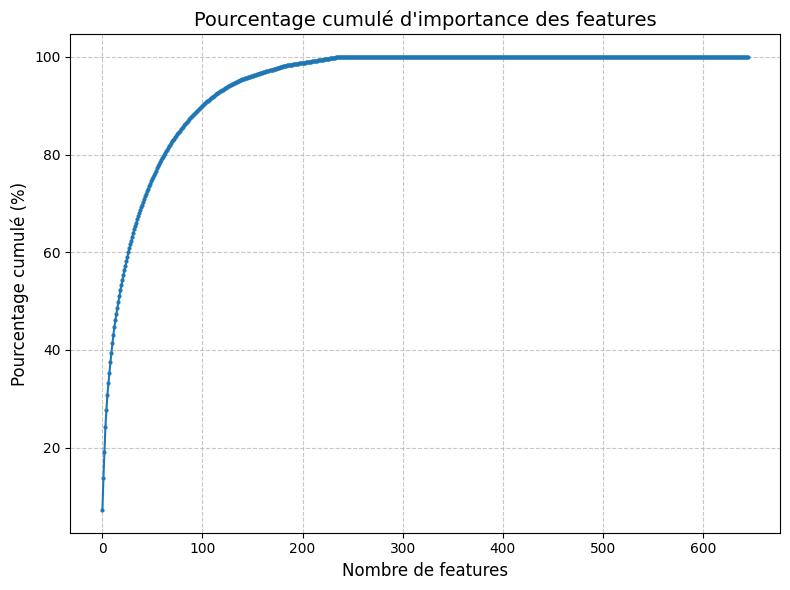


Dimensions après filtrage par importance:
train_df: (307507, 235)
test_df: (48744, 234)


In [31]:
# Créer la visualisation du pourcentage cumulé
plt.figure(figsize=(8, 6))
plt.plot(range(len(feature_imp)), feature_imp["pct_cum"], marker='o', linestyle='-', markersize=2)
plt.xlabel('Nombre de features', fontsize=12)
plt.ylabel('Pourcentage cumulé (%)', fontsize=12)
plt.title('Pourcentage cumulé d\'importance des features', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Sélectionner les features importantes
important_features = list(features_selected['Feature'])

# Inclure TARGET pour le dataframe d'entraînement
important_features_with_target = important_features + ['TARGET']

# Filtrer train_df et test_df pour ne garder que les features importantes
train_df_selected = train_df[important_features_with_target]
test_df_selected = test_df[important_features]

# Dimensions finales
mlflow.log_metric("final_train_features", train_df_selected.shape[1])
mlflow.log_metric("final_test_features", test_df_selected.shape[1])

# Nettoyer le fichier temporaire
import os
if os.path.exists('feature_importance_plot.png'):
    os.remove('feature_importance_plot.png')

print(f"\nDimensions après filtrage par importance:")
print(f"train_df: {train_df_selected.shape}")
print(f"test_df: {test_df_selected.shape}")

# Mettre à jour les DataFrames
train_df = train_df_selected
test_df = test_df_selected

In [32]:
# Extraire les features sélectionnées (sans TARGET)
selected_features = [col for col in train_df.columns if col != 'TARGET']

# Tracking
mlflow.log_metric("final_features_count", len(selected_features))
mlflow.log_metric("final_train_shape_rows", train_df.shape[0])
mlflow.log_metric("final_train_shape_cols", train_df.shape[1])
mlflow.log_metric("final_test_shape_rows", test_df.shape[0])
mlflow.log_metric("final_test_shape_cols", test_df.shape[1])

# Sauvegarder la liste des features finales
import json
features_list = {
    "selected_features": selected_features,
    "total_count": len(selected_features),
    "has_target": "TARGET" in train_df.columns,
    "processing_date": datetime.now().isoformat()
}

mapping_path = os.path.join(project_dir, 'data', 'processed', 'final_features_list.json')
with open(mapping_path, 'w') as f:
    json.dump(features_list, f, indent=2)

mlflow.log_artifact(mapping_path)

# Afficher les résultats
print(f"\nDataFrames finaux prêts:")
print(f"train_df: {train_df.shape} (avec TARGET)")
print(f"test_df: {test_df.shape} (sans TARGET)")
print(f"Features sélectionnées: {len(selected_features)}")
print(f"Liste sauvegardée dans: {mapping_path}")


DataFrames finaux prêts:
train_df: (307507, 235) (avec TARGET)
test_df: (48744, 234) (sans TARGET)
Features sélectionnées: 234
Liste sauvegardée dans: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\processed\final_features_list.json


Sélection des 234 features les plus importantes (99.9% de l'importance cumulée) via un modèle LightGBM rapide. Cette approche automatisée élimine le bruit tout en conservant l'essentiel du signal prédictif. La réduction dimensionnelle améliore l'efficacité computationnelle sans perte de performance.


In [33]:
# Export
data_dir = os.path.join(project_dir, 'data', 'processed')
train_path = os.path.join(data_dir, 'train_preprocessed.csv')
test_path = os.path.join(data_dir, 'test_preprocessed.csv')

# Export
train_df.to_csv(train_path, index=True)
test_df.to_csv(test_path, index=True)

# Tracking
mlflow.log_metric("final_exported_train_rows", train_df.shape[0])
mlflow.log_metric("final_exported_train_features", train_df.shape[1])
mlflow.log_metric("final_exported_test_rows", test_df.shape[0])
mlflow.log_metric("final_exported_test_features", test_df.shape[1])

# Artifacts
mlflow.log_artifact(train_path)
mlflow.log_artifact(test_path)

print(f"Fichiers exportés:")
print(f"- Train: {train_path}")
print(f"- Test: {test_path}")

Fichiers exportés:
- Train: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\processed\train_preprocessed.csv
- Test: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\processed\test_preprocessed.csv


Sauvegarde des datasets finaux optimisés pour la modélisation. Les 234 features sélectionnées représentent l'essence de l'information prédictive extraite des 7 tables originales. Le format preprocessed facilite le chargement rapide pour l'étape de modélisation, réduisant les contraintes mémoire.


# Fermeture du run

In [34]:
if mlflow.active_run():
    run = mlflow.active_run()
    print(f"Fermeture du run MLflow: {run.info.run_name} ")
    mlflow.end_run()

print("Résultat dans MLflow UI http://localhost:5000")

Fermeture du run MLflow: data_credit-scoring-feature-engineering 
🏃 View run data_credit-scoring-feature-engineering at: http://localhost:5000/#/experiments/964351039608613931/runs/1ea239073b73466db5442ae80ce4c943
🧪 View experiment at: http://localhost:5000/#/experiments/964351039608613931
Résultat dans MLflow UI http://localhost:5000


Finalisation du tracking MLflow avec logging de toutes les métriques de performance du feature engineering. Les 649 features créées puis réduites à 234 témoignent d'une approche exhaustive puis sélective. Le succès de cette étape conditionne la qualité de la modélisation suivante.
